# K-Nearest Neighbors


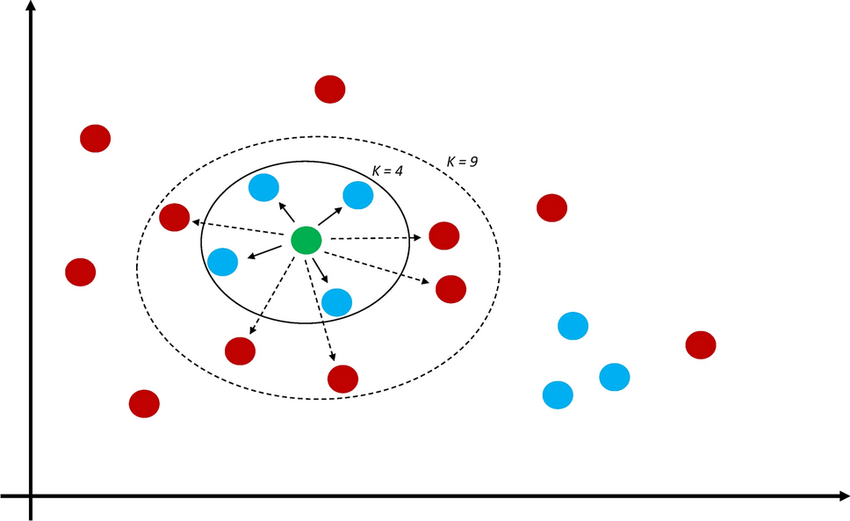

K-Nearest Neighbors (KNN for short) is a non-parametric model that assumes proximity between similar datapoints. 


What is a parameter?

* A parameter refers to a variable that is required by a parametric model to make predictions. Its value is typically estimated from the input data during the learning process. An example is a coefficient vector. 

The models we previously explored, like linear regression and the perceptron, are examples of parametric models. 

What separates a nonparametric model from a parametric model?
* Nonparametric models cannot assume normality of input data
* Nonparametric models typically use continuous values instead of discrete values
* Nonparametric models can automatically ignore nonimportant features, minimizing the need for feature engineering

We will implement the KNN algorithm in this notebook. To briefly reiterate the process, we need to:
1. initialize K
2. Calculate the distances between points and add the (distance, $x_i$) pair to an ordered data structure
3. Sort the data structure by distances in ascending order
4. Get the K data points and return the mean of it for regression tasks, or the mode label for classification. 



In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

auto = pd.read_csv("/Users/kritinshanmugam/Downloads/auto-mpg.csv")
auto = auto[auto['horsepower'] != '?']

car_names = auto['car name']

X = auto.drop(['car name', 'mpg'], axis=1)
X = X.astype('float64')

X = (X - X.mean())/X.std()
X = X[['horsepower', 'weight', 'displacement']].astype('float64')
y = auto['mpg'].astype('float64')
y = np.where(auto['mpg'] < 23, 0, 1)

X = X.values

car_names = pd.DataFrame(car_names, columns=['car name'])

X_train, X_test, y_train, y_test, car_names_train, car_names_test = train_test_split(X, y, car_names, test_size=0.30, random_state=31)

We can use Euclidian distance as our measure of distance between datapoints. The Euclidean distance is defined as:

$\qquad$ $d(x_i, x_j) = \sqrt{(x_i - x_j)^T (x_i - x_j)}$

In [2]:
def distance(p, q):
    return np.sqrt((p - q) @ (p - q))

print(f"The distance between point 10 and 67 is {distance(X[4], X[24])}")

The distance between point 10 and 67 is 1.8829510133331684


Now, we can implement our KNN algorithm. The following algorithm will calculate the nearest $k$ neighbors. 

In [3]:
def k_nearest_neighbors(point, training_features, training_labels, k):
    # Create an empty list to store neighbors and distances
    neighbors = []
    
    for p, label in zip(training_features, training_labels):
        d = distance(point, p)
        temp_data = [p, label, d,]
        neighbors.append(temp_data)
        
    neighbors.sort(key = lambda x : x[-1])
    
    return neighbors[:k]

k_nearest_neighbors(X_test[-1], X_train, y_train, 5)


[[array([-1.07737433, -1.09086578, -0.92133315]), 1, 0.08985186675866692],
 [array([-1.02541435, -1.12853932, -1.03600766]), 1, 0.09071110907959766],
 [array([-1.02541435, -1.12736202, -1.04556387]), 1, 0.09371875683701818],
 [array([-1.15531431, -1.18858152, -1.00733903]), 1, 0.1096335287455741],
 [array([-1.02541435, -1.18034043, -1.03600766]), 1, 0.12121449079203923]]

We can also write a function that predicts a label for classification purposes. As stated before, we could modify this function for regression tasks by calculating the mean of the neighbors. 

In [4]:
def KNN_Predict(point, training_features, training_labels, k, regression = False):
    
    neighbors = k_nearest_neighbors(point, training_features, training_labels, k)
    
    if regression == False:
        labels = [x[1] for x in neighbors]
        return max(labels, key = labels.count)
    
    else:
        return sum(x[1] for x in neighbors)/k
    

# This function will calculate the classification error associated with a specific value of k
def classification_error(test_features, test_labels,training_features, training_labels, k):
    error = 0
    
    for point, label in zip(test_features, test_labels):
        
        error += label != KNN_Predict(point, training_features, training_labels, k)
        
    return error/len(test_features)



### Optimizing the value of K

The value of k can have a strong effect on the accuracy and stability of the KNN model. Generally, the model's accuracy decreases as k decreases. We can use cross validation to find an optimal value of $k$ and minimize our errors. 

The following function will calculate the classification errors for a list of k-values that we provide. 

In [5]:
from sklearn.model_selection import KFold

def knn_cross_validation(training_features, training_labels, k_values, n_folds=5):
    results = {}
    for k in k_values:
        fold_accuracies = []
        
        # This sci-kit learn function will automatically create 5 folds for us to use for cross validation
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
        for train_index, test_index in kf.split(training_features):
            X_train, X_test = training_features[train_index], training_features[test_index]
            y_train, y_test = training_labels[train_index], training_labels[test_index]
            
            # get the classification error. The function will call KNN_Predict()
            class_error = classification_error(X_test, y_test, X_train, y_train, k)
    
            fold_accuracies.append(class_error)
        
        # Store average accuracy for this k
        results[k] = np.mean(fold_accuracies)
    return results
        

### Application on Dataset

Let's now run our KNN algorithm on our Auto-MPG dataset! 

In [8]:
k_vals = [2, 5, 8, 11, 14]

k_accuracies = knn_cross_validation(X_train, y_train, k_vals)

# It seems like a k value of 11 gives us the minimal classification error. However, let's use K = 5 for simplicity. 
    
# Let's test it out on 5 cars 
test = {}
actual = {}
for car_ind in range(10, 15):
    label = KNN_Predict(X_test[car_ind], X_train, y_train, 5)
    car_name = car_names_test.iloc[car_ind]['car name']
    test[car_name] = label
    actual[car_name] = y_test[car_ind]

print("Predicted Labels \n")
print(test)

print("\n Actual Labels")
print(actual)

    

Predicted Labels 

{'datsun 310 gx': 1, 'pontiac sunbird coupe': 1, 'pontiac catalina': 0, 'vw rabbit': 1, 'oldsmobile omega brougham': 1}

 Actual Labels
{'datsun 310 gx': 1, 'pontiac sunbird coupe': 1, 'pontiac catalina': 0, 'vw rabbit': 1, 'oldsmobile omega brougham': 1}


Amazing! We can see that our K-Nearest-Neighbors algorithm successfully classified these five cars from our Auto-MPG dataset. The algorithm decided these labels based on the cars closest to them in characteristics. 

## Conclusion

As we can see, the KNN classification model is able to predict whether a vehicle will be efficient or inefficient, in terms of its MPG. We did not have to perform any feature engineering or tuning. We also saw that the value of $k$ can have a substantial effect on the accuracy of the model. 

KNN is a simple algorithm that can be widely used for many purposes. A popular implementation of KNN is a recommendation system, where a system can recommend similar items (TV Shows, movies, cars, etc.) based on the characteristics of the object already owned. For example, if a movie watcher wants to explore more action movies after just watching one, the system can find more movies based on the characteristics of the action movie the user watched. 

It is important to remember KNN for future tasks, despite its simple nature. It is incredibly effective and can match the performance of more complicated models. 